In [344]:
import os
import pandas as pd
import numpy as np
import pyodbc
from scipy.stats import shapiro
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from collections import OrderedDict


# Download the data

In [345]:
cpa_data = pd.read_excel(r'J:\DataScience\DataQuality\QAQC\Estimates QC Automation\v_series15\individual_files\2022_03\cpa_est_2022_03_population_ind_QA.xlsx')
cpa_data_22 = cpa_data[cpa_data['yr_id']==2022]
cpa_data_22.head()

,cpa,yr_id,Group Quarters - College,Group Quarters - Military,Group Quarters - Other,Household Population,Total Population,Total GQ Population
2,32nd Street Naval Station,2022,0,7610,0,0,7610,7610
5,Alpine,2022,0,0,192,17917,18109,192
8,Balboa Park,2022,0,305,108,0,413,413
11,Barona,2022,0,0,0,906,906,0
14,Barrio Logan,2022,0,0,646,3239,3885,646


In [346]:
cpa_diff_data = pd.read_excel(r'J:\DataScience\DataQuality\QAQC\Estimates QC Automation\v_series15\diff_files\2022_03\cpa_population_est_2022_03_minus_2021_01_QA.xlsx', sheet_name='Diff')
cpa_diff_data_22 = cpa_diff_data[cpa_diff_data['yr_id']==2021]
cpa_diff_data_22

,cpa,yr_id,Total Population,Household Population,Group Quarters - Military,Group Quarters - College,Group Quarters - Other
1,32nd Street Naval Station,2021,-57,0,-57,0,0
3,Alpine,2021,786,746,0,0,40
5,Balboa Park,2021,9,0,-2,0,11
7,Barona,2021,47,48,0,0,-1
9,Barrio Logan,2021,-145,-610,0,0,465
...,...,...,...,...,...,...,...
157,University,2021,-1792,-3491,0,1162,537
159,Uptown,2021,-9484,-10042,0,0,558
161,Valle De Oro,2021,1562,1375,0,0,187
163,Valley Center,2021,1865,1867,0,0,-2


# Testing for normal distribution
I will use the Shapiro-Wilk test

In [347]:
# Perform the Shapiro-Wilk test on the population data
stat, p = shapiro(cpa_data_22['Total Population'])

# Interpret the Shapiro-Wilk test results
alpha = 0.05
if p > alpha:
    print('Population data is normally distributed (fail to reject H0)')
else:
    print('Population data is not normally distributed (reject H0)')


Population data is not normally distributed (reject H0)


In [348]:
# Perform the Shapiro-Wilk test on the population data
stat, p = shapiro(cpa_diff_data_22['Total Population'])

# Interpret the Shapiro-Wilk test results
alpha = 0.05
if p > alpha:
    print('Population data is normally distributed (fail to reject H0)')
else:
    print('Population data is not normally distributed (reject H0)')

Population data is not normally distributed (reject H0)


# Interquartile Range Method

In [349]:
# Calculate the first and third quartiles of the 'Total Population' column
Q1 = cpa_diff_data_22['Total Population'].quantile(0.25)
Q3 = cpa_diff_data_22['Total Population'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Set the outlier threshold to 1.5 times the IQR
outlier_threshold = 1.5 * IQR

# Find the outliers in the 'Total Population' column
outliers = cpa_diff_data_22[(cpa_diff_data_22['Total Population'] < Q1 - outlier_threshold) | (cpa_diff_data_22['Total Population'] > Q3 + outlier_threshold)]

outliers

,cpa,yr_id,Total Population,Household Population,Group Quarters - Military,Group Quarters - College,Group Quarters - Other
21,Clairemont Mesa,2021,4717,4756,0,0,-39
33,Downtown,2021,-18834,-17470,0,20,-1384
39,Fallbrook,2021,3551,3405,0,0,146
43,Greater Golden Hill,2021,-3119,-3172,0,0,53
45,Greater North Park,2021,-11226,-11196,0,0,-30
57,Lakeside,2021,4875,4996,0,0,-121
71,Mid-City:Normal Heights,2021,-3120,-3122,0,0,2
75,Mira Mesa,2021,6781,7017,0,0,-236
85,Mission Valley,2021,-6066,-5999,0,0,-67
107,Otay Mesa-Nestor,2021,7061,7170,0,0,-109


# Adjusting for CPA size values 

In [350]:
compact_data = cpa_data_22[['cpa', 'Total Population']].merge(cpa_diff_data_22[['cpa', 'Total Population']], how='right', on='cpa', suffixes=['_Tot', '_Diff'])
compact_data['Total Population_Diff_abs'] = abs(compact_data['Total Population_Diff'])
compact_data

,cpa,Total Population_Tot,Total Population_Diff,Total Population_Diff_abs
0,32nd Street Naval Station,7610,-57,57
1,Alpine,18109,786,786
2,Balboa Park,413,9,9
3,Barona,906,47,47
4,Barrio Logan,3885,-145,145
...,...,...,...,...
78,University,75485,-1792,1792
79,Uptown,40817,-9484,9484
80,Valle De Oro,42302,1562,1562
81,Valley Center,20560,1865,1865


AxesSubplot(0.125,0.125;0.775x0.755)


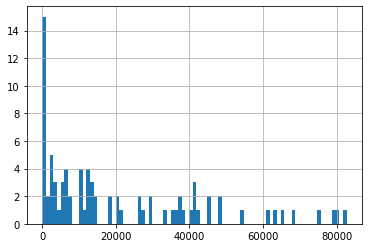

In [351]:
# Do household population and GQ differently 
print(compact_data['Total Population_Tot'].hist(bins=83))

# create the frequency table 

AxesSubplot(0.125,0.125;0.775x0.755)


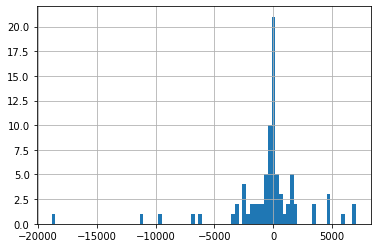

In [352]:
print(compact_data['Total Population_Diff'].hist(bins=83))

In [353]:
df = compact_data

# Calculate the z-score of each 'Total Population' value based on similar cpas
df['pop_diff_zscore'] = np.nan
df['group_mean'] = np.nan
df['group_std'] = np.nan

for i, row in df.iterrows():
    cpa_population = row['Total Population_Tot']
    similar_cpas = df[(df['Total Population_Tot'] >= cpa_population - 5000) & (df['Total Population_Tot'] <= cpa_population + 5000)]
    mu = similar_cpas['Total Population_Diff_abs'].mean()
    sigma = similar_cpas['Total Population_Diff_abs'].std()
    zscore = (row['Total Population_Diff_abs'] - mu) / sigma
    df.at[i, 'pop_diff_zscore'] = zscore
    df.at[i, 'group_mean'] = round(mu, 2)
    df.at[i, 'group_std'] = round(sigma,2)

df.head(10)

,cpa,Total Population_Tot,Total Population_Diff,Total Population_Diff_abs,pop_diff_zscore,group_mean,group_std
0,32nd Street Naval Station,7610,-57,57,-0.939099,647.39,628.68
1,Alpine,18109,786,786,-0.593307,1514.50,1227.86
2,Balboa Park,413,9,9,-0.540018,331.32,596.87
3,Barona,906,47,47,-0.481580,329.31,586.22
4,Barrio Logan,3885,-145,145,-0.350150,349.00,582.61
5,Black Mountain Ranch,13804,17,17,-1.149271,1261.38,1082.75
6,Bonsall,10602,259,259,-0.772610,1085.85,1070.20
7,Carmel Mountain Ranch,12297,-526,526,-0.591938,1198.19,1135.57
8,Carmel Valley,35194,-1065,1065,-0.405236,1475.00,1011.76
9,Central Mountain,4884,-429,429,0.137314,349.00,582.61


# Working with MGRA values

In [354]:
mgra_data = pd.read_excel(r'J:\DataScience\DataQuality\QAQC\Estimates QC Automation\v_series15\individual_files\2022_03\mgra_est_2022_03_ethnicity_ind_QA.xlsx')
mgra_data_21 = mgra_data[mgra_data['yr_id']==2021]
mgra_data_21 = mgra_data_21[['mgra', 'Hispanic']]
mgra_data_21

,mgra,Hispanic
1,1,126
4,2,36
7,3,126
10,4,0
13,5,19
...,...,...
72949,24317,0
72952,24318,0
72955,24319,0
72958,24320,0


In [355]:
mgra_diff_data = pd.read_excel(r'J:\DataScience\DataQuality\QAQC\Estimates QC Automation\v_series15\diff_files\2022_03\mgra_ethnicity_est_2022_03_minus_2022_02_QA.xlsx', sheet_name='Diff')
mgra_diff_data = mgra_diff_data[mgra_diff_data['yr_id']==2021]
mgra_diff_data_21 = mgra_diff_data[['mgra', 'Hispanic']]
mgra_diff_data_21

,mgra,Hispanic
1,1,13
4,2,6
7,3,-3
10,4,0
13,5,1
...,...,...
72949,24317,0
72952,24318,-3
72955,24319,0
72958,24320,0


In [356]:
combined_data = mgra_data_21.merge(mgra_diff_data_21, on='mgra', suffixes=['_Tot', '_Diff'])
combined_data['Hispanic_Diff_Abs'] = abs(combined_data['Hispanic_Diff'])
#combined_data = combined_data[combined_data['Hispanic_Tot'] != 0]
combined_data

,mgra,Hispanic_Tot,Hispanic_Diff,Hispanic_Diff_Abs
0,1,126,13,13
1,2,36,6,6
2,3,126,-3,3
3,4,0,0,0
4,5,19,1,1
...,...,...,...,...
24316,24317,0,0,0
24317,24318,0,-3,3
24318,24319,0,0,0
24319,24320,0,0,0


In [357]:
df = combined_data.head(1000)

# Calculate the z-score of each 'Total Population' value based on similar cpas
df['pop_diff_zscore'] = np.nan
df['group_mean'] = np.nan
df['group_std'] = np.nan

for i, row in df.iterrows():
    cpa_population = row['Hispanic_Tot']
    similar_cpas = df[(df['Hispanic_Tot'] >= cpa_population - 10) & (df['Hispanic_Tot'] <= cpa_population + 10)]
    means = bootstrap_mean(similar_cpas['Hispanic_Diff_Abs'], n_bootstraps=100)
    mean_of_means = np.mean(means)
    se_of_means = np.std(means)

    zscore = (row['Hispanic_Diff_Abs'] - mean_of_means) / se_of_means
    df.at[i, 'pop_diff_zscore'] = zscore
    df.at[i, 'group_mean'] = round(mean_of_means, 2)
    df.at[i, 'group_std'] = round(se_of_means,2)

df.head(10)

,mgra,Hispanic_Tot,Hispanic_Diff,Hispanic_Diff_Abs,pop_diff_zscore,group_mean,group_std
0,1,126,13,13,3.111217,6.03,2.24
1,2,36,6,6,0.701845,5.56,0.63
2,3,126,-3,3,-1.468518,5.85,1.94
3,4,0,0,0,-7.671248,1.73,0.23
4,5,19,1,1,-6.984769,3.74,0.39
5,6,16,2,2,-5.329516,3.39,0.26
6,7,24,8,8,8.958071,4.38,0.40
7,8,14,2,2,-4.581233,3.06,0.23
8,9,474,3,3,NaN,3.00,0.00
9,10,8,2,2,-0.639594,2.12,0.18


# Bootstrap (Central Limit Theorem)

In [358]:
df = compact_data

# Define a function to bootstrap the mean
def bootstrap_mean(data, n_bootstraps=1000):
    means = np.zeros(n_bootstraps)
    for i in range(n_bootstraps):
        sample = np.random.choice(data, size=len(data), replace=True)
        means[i] = np.mean(sample)
    return means

# Bootstrap the mean of the "Total Population_Diff" column
bootstrapped_means = bootstrap_mean(df['Total Population_Diff'])

# Calculate the mean and standard error of the mean of the bootstrapped means
mean_of_means = np.mean(bootstrapped_means)
se_of_means = np.std(bootstrapped_means)

# Print the mean and standard error of the mean
print(f"Mean of means: {mean_of_means}")
print(f"Standard error of means: {se_of_means}")


Mean of means: -351.60139759036144
Standard error of means: 350.8096180245844


# Dynamic Binning

In [359]:
def original_lower_and_upper_index(data_series, index):
    if index != 0:
        lower_index = index - 1
    else:
        lower_index = index 
    
    if index != len(data_series):
        upper_index = index + 1
    else:
        upper_index = index
    
    return lower_index, upper_index


In [360]:
def new_lower_and_upper_index(data_series, lower_index, upper_index):
    if lower_index != 0:
        lower_index = lower_index - 1
    else:
        lower_index = lower_index 
    
    if upper_index != len(data_series):
        upper_index = upper_index + 1
    else:
        upper_index = upper_index
    
    return lower_index, upper_index

In [361]:
def dynamic_binning(data_series, target_num):
    '''This function accepts a pandas DataFrame column containing a series of data and a target value as input. The target value must exist within the series. The function returns the lower and upper bounds that need to be filtered so that the number of records in the column is greater than 30. If there are enough records at the target value alone, the target value is returned.

    Parameters:
    data (pandas DataFrame column): The series of data in question.
    target_value (any): The value to filter the data by.
    Returns:

    If the number of records at the target value is greater than or equal to 30, the target value is returned.
    Otherwise, the function returns a tuple containing the lower and upper bounds (inclusive) that need to be filtered in order to obtain at least 30 records in the column.'''
    freq_table_sorted = data_series.value_counts().sort_index()

    freq_table_dict = freq_table_sorted.to_dict()
    list_of_sorted_dict = OrderedDict(sorted(freq_table_dict.items()))

    if target_num not in list(data_series):
        return f"{target_num} is not found in the data series given."

    index = None
    for i, key in enumerate(list_of_sorted_dict.keys()):
        if key == target_num:
            index = i
            break

    freq_table_sorted = freq_table_sorted.reset_index(drop=True)

    if (freq_table_sorted.loc[[index]] > 30).all():
        return index
    else:
        lower, upper = original_lower_and_upper_index(data_series, index)
        while sum(freq_table_sorted.loc[[x for x in range(lower, upper)]]) < 30:
            lower, upper = new_lower_and_upper_index(data_series=freq_table_sorted, lower_index=lower, upper_index=upper)
        return (lower, upper)


In [362]:
dynamic_binning(data_series=combined_data['Hispanic_Tot'], target_num=100)

100